In [5]:
import pandas as pd
from pgmpy.inference import VariableElimination, CausalInference

def compute_bibas_pairwise(model, source, target, target_positive_state=1, operation="observe"):
    """
    Compute the BIBAS score from source → target (target must be binary).
    
    Parameters:
        model : pgmpy.models.DiscreteBayesianNetwork
            The Bayesian network model.
        source : str
            Source variable name.
        target : str
            Target variable name (must have exactly two states).
        target_positive_state : int | str, optional (default=1)
            The state of the target considered "positive" – either its index (0/1)
            or its state-name (e.g. "yes").
        operation : {'observe', 'do'}, optional (default='observe')
            • 'observe' - updates P(T) given evidence X = xᵢ.  
            • 'do'      - updates P(T) under intervention do(X = xᵢ).
    
    Returns:
        float – BIBAS score (0–100), or None if computation fails
    """
    # Helper: convert index → state-name when state_names are defined
    def _state_val(cpd, var, idx_or_name):
        if isinstance(idx_or_name, int) and cpd.state_names.get(var):
            return cpd.state_names[var][idx_or_name]
        return idx_or_name

    try:
        source_cpd = model.get_cpds(source)
        target_cpd = model.get_cpds(target)

        if target_cpd.variable_card != 2:
            raise ValueError("Target must be binary (exactly two states)")

        # Resolve positive state name and its index
        t_pos_name = _state_val(target_cpd, target, target_positive_state)
        t_states   = target_cpd.state_names.get(target, [0, 1])
        t_pos_idx  = t_states.index(t_pos_name) if isinstance(t_pos_name, str) else t_pos_name

        # Prior probability of T+
        elim = VariableElimination(model)
        p_t_pos = elim.query([target], show_progress=False).values[t_pos_idx]

        # Prior distribution of X (weights for aggregation)
        p_x = elim.query([source], show_progress=False).values

        shifts = []

        if operation == "observe":
            # Evidence-based posterior
            for i, weight in enumerate(p_x):
                if weight == 0:
                    continue  # skip impossible state
                evidence_val = _state_val(source_cpd, source, i)
                posterior = elim.query(
                    variables=[target],
                    evidence={source: evidence_val},
                    show_progress=False,
                ).values[t_pos_idx]
                shifts.append(weight * abs(posterior - p_t_pos))

        elif operation == "do":
            # Intervention-based posterior
            if target in model.get_parents(source):
                return 0.0  # causal influence child→parent is undefined (treated as 0)

            cinf = CausalInference(model)
            for i, weight in enumerate(p_x):
                if weight == 0:
                    continue
                do_val = _state_val(source_cpd, source, i)
                posterior = cinf.query(
                    variables=[target],
                    do={source: do_val},
                    show_progress=False,
                ).values[t_pos_idx]
                shifts.append(weight * abs(posterior - p_t_pos))

        else:
            raise ValueError("operation must be 'observe' or 'do'")

        return sum(shifts) * 100

    except Exception as e:
        print(f"[BIBAS Error] {e}")
        return None

In [6]:
def rank_sources_for_target(model, target, target_positive_state=1, operation="observe"):
    """
    Ranks all source nodes by their BIBAS score on a given binary target.
    
    Parameters:
        model: pgmpy.models.DiscreteBayesianNetwork
        target: str – name of the target node (must be binary)
        target_positive_state: int – state of the target considered "positive"
        operation: 'observe' or 'do'
    
    Returns:
        pd.DataFrame with columns: ['source', 'bibas_score'], sorted descending
    """
    target_card = model.get_cpds(target).variable_card
    if target_card != 2:
        raise ValueError("Target must be binary")

    sources = [node for node in model.nodes() if node != target]

    rows = []
    for src in sources:
        score = compute_bibas_pairwise(
            model,
            source=src,
            target=target,
            target_positive_state=target_positive_state,
            operation=operation
        )
        rows.append({"source": src, "bibas_score": score})

    df = pd.DataFrame(rows).sort_values("bibas_score", ascending=False).reset_index(drop=True)
    return df

In [7]:
import sys
import contextlib
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display
from pgmpy.models import BayesianNetwork, DiscreteBayesianNetwork

def plot_binary_bibas_heatmap(model, operation="observe", filename=None, title=None):
    """
    Plots a heatmap showing the BIBAS score from each source variable to each target variable
    in a fully binary Bayesian Network.

    Parameters:
        model: DiscreteBayesianNetwork – a BN with only binary variables
        operation: str – 'observe' (default) uses evidence; 'do' uses intervention (do-calculus)
        filename: str – if provided, saves the plot to file (PNG)
        title: str – optional custom title for the heatmap
    """
    nodes = sorted(model.nodes())

    # Validate that all variables in the network are binary
    for node in nodes:
        cpd = model.get_cpds(node)
        if cpd.variable_card != 2:
            raise ValueError(f"All nodes must be binary. Node '{node}' has {cpd.variable_card} states.")

    # Compute the BIBAS score from each source node to each target node
    bibas_matrix = pd.DataFrame(index=nodes, columns=nodes)
    for src in nodes:
        for tgt in nodes:
            if src == tgt:
                bibas_matrix.loc[src, tgt] = np.nan  # self-impact is visually excluded
            else:
                try:
                    score = compute_bibas_pairwise(model, src, tgt, target_positive_state=1, operation=operation)
                    bibas_matrix.loc[src, tgt] = 0.0 if score is None else score  # treat invalid/undefined as 0
                except:
                    bibas_matrix.loc[src, tgt] = 0.0  # fallback in case of any inference error

    bibas_matrix = bibas_matrix.astype(float)

    # Create the heatmap
    n = len(nodes)
    fig, ax = plt.subplots(figsize=(1.2 * n, 1.1 * n))
    sns.heatmap(
        bibas_matrix,
        annot=True,             # show score values in cells
        fmt=".1f",              # one decimal point
        cmap='Reds',            # white to red gradient
        square=True,
        linewidths=0.5,
        linecolor='white',
        mask=np.eye(n, dtype=bool),  # mask diagonal
        cbar_kws={"label": "BIBAS Score", "shrink": 0.6},
        ax=ax
    )

    # Add hatched rectangles on the diagonal to visually indicate self-impact is excluded
    for i in range(n):
        rect = patches.Rectangle((i, i), 1, 1, hatch='///',
                                 fill=False, edgecolor='gray', linewidth=0)
        ax.add_patch(rect)

    # Add title and labels
    ax.set_title(title or f"BIBAS Factor (operation = '{operation}')", fontsize=14)
    ax.set_xlabel("Target Node")
    ax.set_ylabel("Source Node")
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Output: either save to file or display interactively
    if filename:
        plt.savefig(filename, bbox_inches="tight", dpi=300)
        plt.close()
    else:
        with contextlib.redirect_stderr(sys.__stdout__):
            plt.show()

In [8]:
def plot_ranked_sources_for_target(model, target, target_positive_state=1, operation="observe", filename=None, title=None):
    """
    Plot a horizontal bar chart ranking all sources by their BIBAS impact on a given binary target.

    Parameters:
        model: pgmpy Bayesian Network
        target: str – target node (must be binary)
        target_positive_state: int – which state is considered "positive"
        operation: 'observe' or 'do'
        filename: str – optional path to save the plot
        title: str – optional custom plot title
    """
    try:
        df = rank_sources_for_target(model, target, target_positive_state, operation)

        plt.figure(figsize=(10, 0.5 * len(df)))
        sns.barplot(data=df, x="bibas_score", y="source", hue="source", palette="Reds_r", legend=False)

        plt.xlabel("BIBAS Score")
        plt.ylabel("Source Node")
        plt.title(title or f"BIBAS Ranking on Target: '{target}' (operation = '{operation}')")

        # Annotate bars with values
        for i, row in df.iterrows():
            plt.text(row.bibas_score + 0.5, i, f"{row.bibas_score:.1f}", va='center')

        plt.xlim(0, df["bibas_score"].max() * 1.1)
        plt.tight_layout()

        if filename:
            plt.savefig(filename, bbox_inches="tight", dpi=300)
            plt.close()
        else:
            with contextlib.redirect_stderr(sys.__stdout__):
                plt.show()

    except Exception as e:
        print(f"[BIBAS Error] {e}")

In [9]:
def plot_bn(model, layout=nx.spring_layout, type="none", target=None, operation="observe", filename=None, title=None):
    """
    Plot a Bayesian Network with optional BIBAS-based node/edge analysis.

    Parameters:
        model: pgmpy.models.DiscreteBayesianNetwork
        layout: function
        type: str
        target: str (optional)
        operation: str
        filename: str (optional)
        title: str (optional)
    """
    if not isinstance(model, DiscreteBayesianNetwork):
        raise ValueError("Input must be a pgmpy DiscreteBayesianNetwork.")

    nodes = sorted(model.nodes())
    edges = model.edges()
    G = nx.DiGraph(edges)
    pos = layout(G, seed=42)

    def is_binary(node):
        return model.get_cpds(node).variable_card == 2

    if type in ['edges', 'edges_and_impacts']:
        non_binary_nodes = [n for n in nodes if not is_binary(n)]
        if non_binary_nodes:
            raise ValueError(f"Edge-based visualization requires all nodes to be binary. Non-binary: {non_binary_nodes}")

    node_colors = {}
    edge_colors = {}
    edge_labels = {}
    node_labels = {n: n for n in nodes}

    if type == "none":
        node_colors = {n: "skyblue" for n in nodes}

    elif type == "blanket":
        if not target:
            raise ValueError("Target must be specified for type='blanket'")
        blanket = set(model.get_markov_blanket(target))
        for node in nodes:
            if node == target:
                node_colors[node] = "lightgreen"
            elif node in blanket:
                node_colors[node] = "salmon"
            else:
                node_colors[node] = "skyblue"

    elif type == "impacts":
        if not target:
            raise ValueError("Target must be specified for type='impacts'")
        bibas_scores = {
            node: compute_bibas_pairwise(model, node, target, operation=operation)
            if node != target else None
            for node in nodes
        }
        valid_scores = [v for v in bibas_scores.values() if v is not None]
        min_score, max_score = min(valid_scores), max(valid_scores)

        for node in nodes:
            if node == target:
                node_colors[node] = "lightgreen"
            else:
                score = bibas_scores[node]
                norm = (score - min_score) / (max_score - min_score) if max_score > min_score else 0
                intensity = 0.2 + norm * 0.6
                node_colors[node] = (1, 1 - intensity, 1 - intensity)
                node_labels[node] = f"{node}\n{score:.2f}"

    elif type == "edges":
        scores = []
        for (src, tgt) in edges:
            score = compute_bibas_pairwise(model, src, tgt, operation=operation)
            scores.append(score)
            edge_labels[(src, tgt)] = f"{score:.1f}"

        min_score, max_score = min(scores), max(scores)
        for (src, tgt), score in zip(edges, scores):
            norm = (score - min_score) / (max_score - min_score) if max_score > min_score else 0
            intensity = 0.2 + norm * 0.6
            edge_colors[(src, tgt)] = (1, 1 - intensity, 1 - intensity)

        node_colors = {n: "skyblue" for n in nodes}

    elif type == "edges_and_impacts":
        if not target:
            raise ValueError("Target must be specified for type='edges_and_impacts'")

        # Node impacts
        bibas_scores = {
            node: compute_bibas_pairwise(model, node, target, operation=operation)
            if node != target else None
            for node in nodes
        }
        valid_node_scores = [v for v in bibas_scores.values() if v is not None]
        min_node, max_node = min(valid_node_scores), max(valid_node_scores)

        for node in nodes:
            if node == target:
                node_colors[node] = "lightgreen"
            else:
                score = bibas_scores[node]
                norm = (score - min_node) / (max_node - min_node) if max_node > min_node else 0
                intensity = 0.2 + norm * 0.6
                node_colors[node] = (1, 1 - intensity, 1 - intensity)
                node_labels[node] = f"{node}\n{score:.2f}"

        # Edge impacts
        edge_scores = []
        for (src, tgt) in edges:
            score = compute_bibas_pairwise(model, src, tgt, operation=operation)
            edge_labels[(src, tgt)] = f"{score:.1f}"
            edge_scores.append(score)

        min_edge, max_edge = min(edge_scores), max(edge_scores)
        for (src, tgt), score in zip(edges, edge_scores):
            norm = (score - min_edge) / (max_edge - min_edge) if max_edge > min_edge else 0
            intensity = 0.2 + norm * 0.6
            edge_colors[(src, tgt)] = (1, 1 - intensity, 1 - intensity)

    else:
        raise ValueError(f"Unknown type: '{type}'. Valid options: none, blanket, impacts, edges, edges_and_impacts.")

    fig, ax = plt.subplots(figsize=(1.2 * len(nodes), 1.2 * len(nodes)))

    nx.draw_networkx_nodes(G, pos, node_color=[node_colors.get(n, "gray") for n in G.nodes()], node_size=1500, ax=ax)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, ax=ax)

    if type in ["edges", "edges_and_impacts"]:
        edge_list = list(edge_colors.keys())
        edge_color_vals = list(edge_colors.values())
        nx.draw_networkx_edges(
            G, pos,
            edgelist=edge_list,
            edge_color=edge_color_vals,
            edge_cmap=plt.cm.Reds,
            arrows=True,
            arrowstyle='->',
            node_size=1500,
            width=2,
            ax=ax
        )
        nx.draw_networkx_edge_labels(
            G, pos, edge_labels=edge_labels, font_size=8, ax=ax, label_pos=0.5
        )
    else:
        nx.draw_networkx_edges(
            G, pos,
            edge_color="gray",
            arrows=True,
            arrowstyle='->',
            node_size=1500,
            ax=ax
        )

    if title:
        plt.title(title, fontsize=14)
    else:
        default_title = {
            "none": "BN Visualization (Simple)",
            "blanket": f"BN Visualization (Markov Blanket of '{target}')",
            "impacts": f"BN Visualization (Nodes Impact Over '{target}')",
            "edges": "BN Visualization (Edge Impacts)",
            "edges_and_impacts": f"BN Visualization (Edges Impact & Nodes Impact Over '{target}')"
        }
        plt.title(default_title.get(type, f"BN Visualization ({type})"), fontsize=14)

    plt.axis("off")

    if type == "blanket":
        legend_handles = [
            patches.Patch(color="lightgreen", label="Target"),
            patches.Patch(color="salmon", label="Markov Blanket"),
            patches.Patch(color="skyblue", label="Other Nodes")
        ]
        plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True)

    plt.tight_layout()

    if filename:
        plt.savefig(filename, bbox_inches="tight", dpi=300)
        plt.close()
    else:
        with contextlib.redirect_stderr(sys.__stdout__):
            plt.show()

## Student network demo

The Student Bayesian network describes how intelligence, course difficulty, motivation, grade, and SAT score affect whether a student receives a strong recommendation letter.

### Nodes (compact six-node version)
- intelligence: high or low  
- difficulty: hard or easy course  
- motivation: high or low  
- grade: high or low  
- sat: high or low  
- letter: strong or weak recommendation  


In [11]:
from pgmpy.utils import get_example_model
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
import networkx as nx

### Loading or generating the Student network

In [13]:
try:
    model = get_example_model("student")         # pgmpy ≥ 0.1.22
except Exception:
    # --- structure --------------------------------------------------------
    edges = [
        ("Intelligence", "Grade"),
        ("Difficulty",   "Grade"),
        ("Motivation",   "Grade"),
        ("Intelligence", "SAT"),
        ("Motivation",   "SAT"),
        ("Grade",        "Letter")
    ]
    model = DiscreteBayesianNetwork(edges)

    # --- CPDs (binary 0/1 everywhere) -------------------------------------
    cpd_I  = TabularCPD("Intelligence", 2, [[0.7], [0.3]])       # 1 = high
    cpd_D  = TabularCPD("Difficulty",   2, [[0.6], [0.4]])       # 1 = hard
    cpd_M  = TabularCPD("Motivation",   2, [[0.5], [0.5]])       # 1 = high

    # Grade | I, D, M   (order: I, D, M)
    cpd_G = TabularCPD(
        "Grade", 2,
        values=[
            #  P(G = low)
            [0.95, 0.85, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30],
            #  P(G = high)
            [0.05, 0.15, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70],
        ],
        evidence=["Intelligence", "Difficulty", "Motivation"],
        evidence_card=[2, 2, 2],
    )

    # SAT | I, M  (order: I, M)
    cpd_S = TabularCPD(
        "SAT", 2,
        values=[
            [0.95, 0.85, 0.75, 0.60],   # SAT = low
            [0.05, 0.15, 0.25, 0.40],   # SAT = high
        ],
        evidence=["Intelligence", "Motivation"],
        evidence_card=[2, 2],
    )

    # Letter | Grade   (0 = weak, 1 = strong)
    cpd_L = TabularCPD(
        "Letter", 2,
        values=[[0.1, 0.8], [0.9, 0.2]],
        evidence=["Grade"],
        evidence_card=[2],
    )

    model.add_cpds(cpd_I, cpd_D, cpd_M, cpd_G, cpd_S, cpd_L)
    assert model.check_model()

### We can also plot and observe it's structure

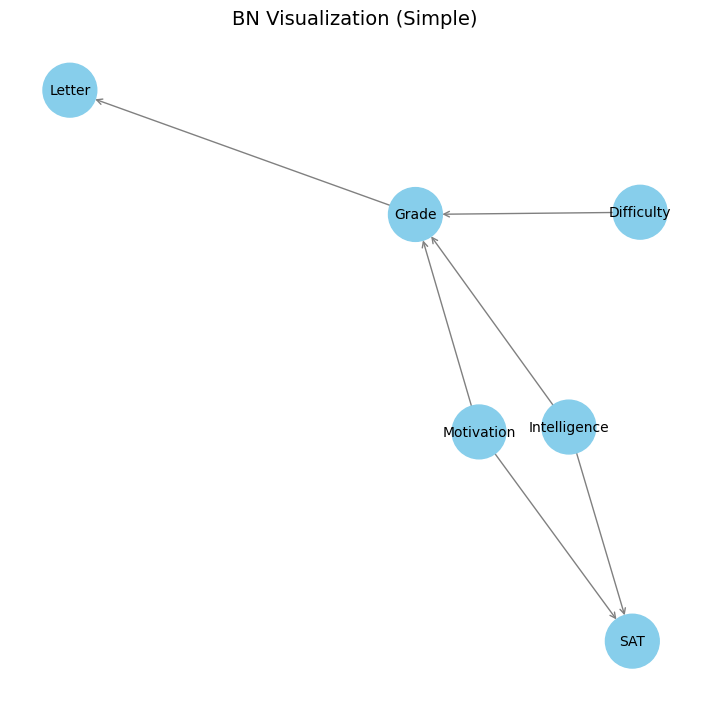

In [22]:
import networkx as nx

# 1. Default network
plot_bn(model, layout=nx.spring_layout, type="none")

### Lets define our 'target' to be Dyspnea, as the focus is on positive cases (dysp = yes)

In [38]:
# ▸ target and state conventions
target = "Letter"
pos = 1         # 1 = strong letter (positive state)

### Printing BIBAS scores for each source (for both 'observe' and 'do' operations)

In [26]:
for op in ["observe", "do"]:
    df = rank_sources_for_target(
        model,
        target=target,
        target_positive_state=pos,
        operation=op,
    )
    print(f"\nBIBAS ranking on Letter – operation = '{op}':")
    print(df.to_string(index=False, formatters={"bibas_score": "{:.2f}".format}))



BIBAS ranking on Letter – operation = 'observe':
      source bibas_score
       Grade       27.66
Intelligence       10.88
  Difficulty        5.54
  Motivation        3.50
         SAT        2.85

BIBAS ranking on Letter – operation = 'do':
      source bibas_score
       Grade       27.66
Intelligence       10.88
  Difficulty        5.54
  Motivation        3.50
         SAT        0.00


### There is also a dedicated function for calculating and plotting this ranking

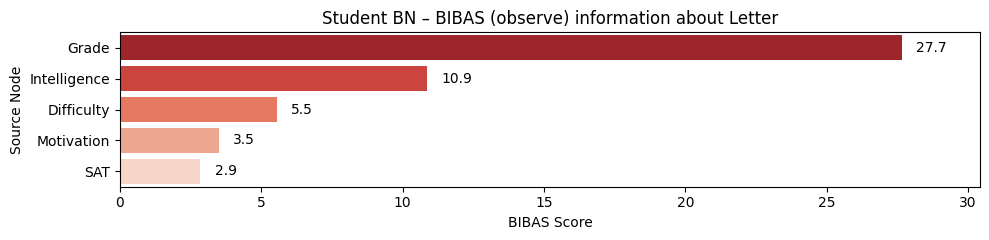

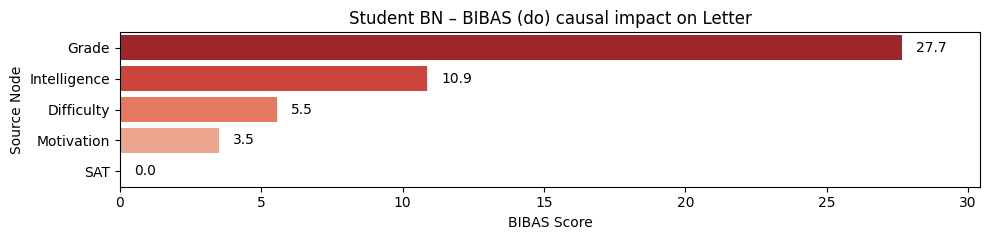

In [30]:
plot_ranked_sources_for_target(
    model,
    target=target,
    target_positive_state=pos,
    operation="observe",
    title="Student BN – BIBAS (observe) information about Letter"
)

plot_ranked_sources_for_target(
    model,
    target=target,
    target_positive_state=pos,
    operation="do",
    title="Student BN – BIBAS (do) causal impact on Letter"
)

### In binary BNs (e.g., all variables have but 2 states), we can compute and plot the score between each pair

#### Notice the differences between the 'do' and 'observe' operations

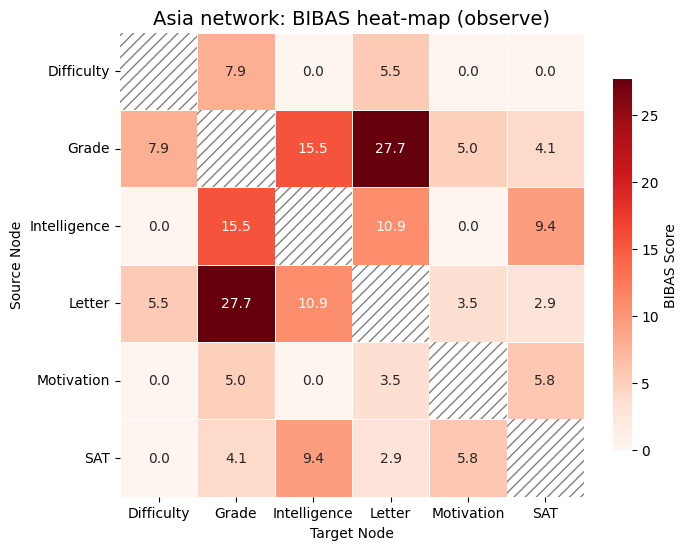

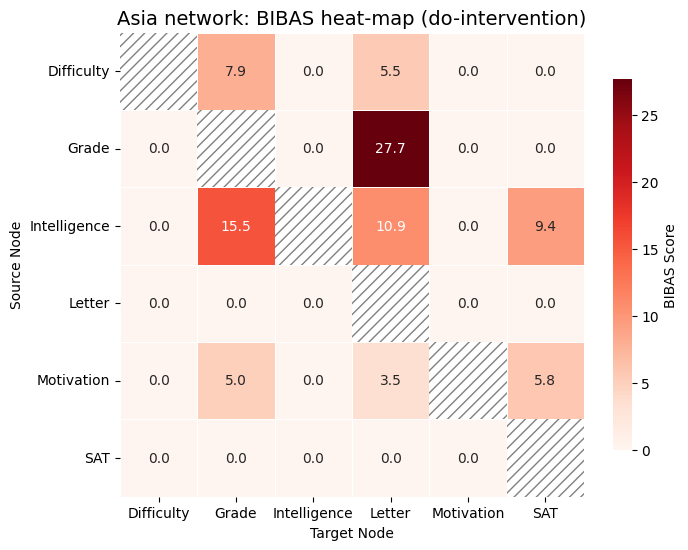

In [32]:
plot_binary_bibas_heatmap(
    model,
    operation="observe",
    title="Asia network: BIBAS heat-map (observe)"
)

plot_binary_bibas_heatmap(
    model,
    operation="do",
    title="Asia network: BIBAS heat-map (do-intervention)"
)

### Now it is time to examine the effects OVER the structure of the network istelf, using the various options of 'plot_bn'

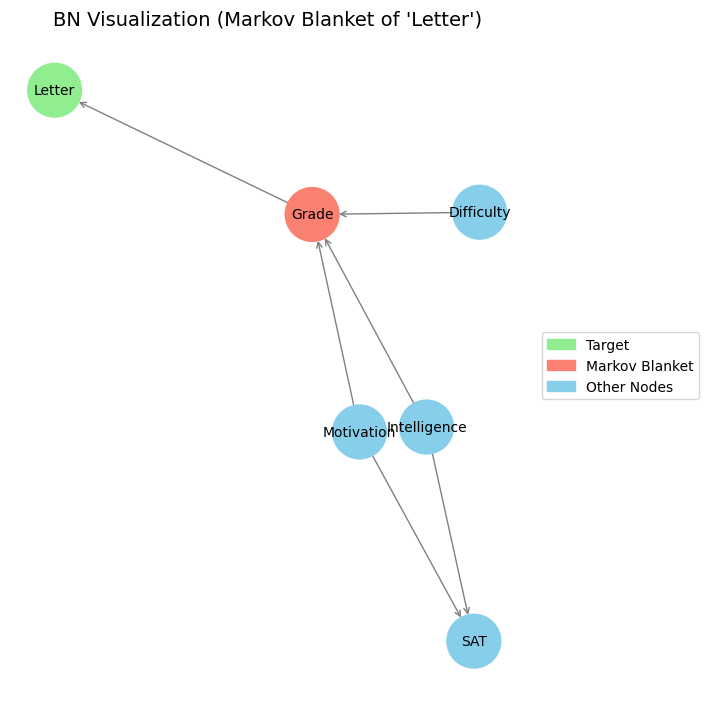

In [34]:
# 2. Markov blanket of Dyspnea
plot_bn(model, layout=nx.spring_layout, type="blanket", target=TARGET)

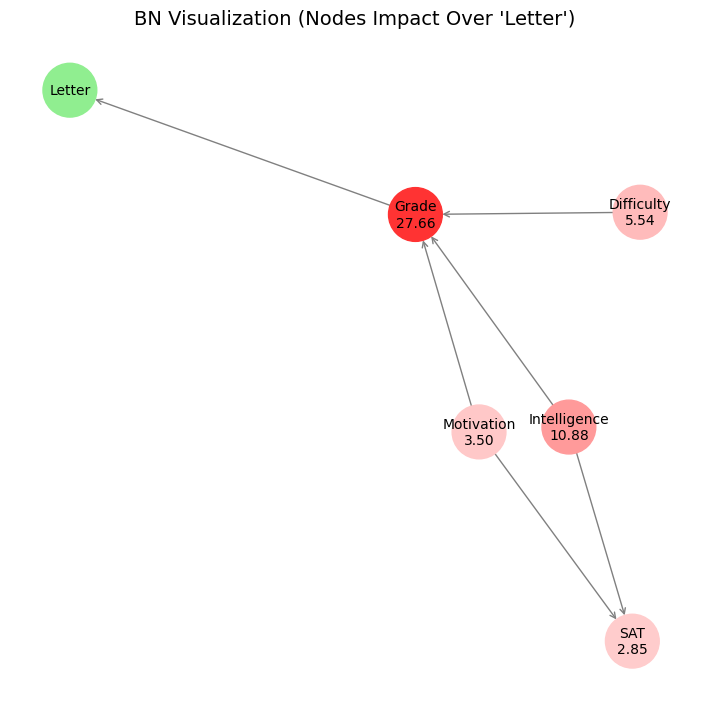

In [40]:
# 3. Node impacts to Dyspnea
plot_bn(model, layout=nx.spring_layout, type="impacts", target=target)

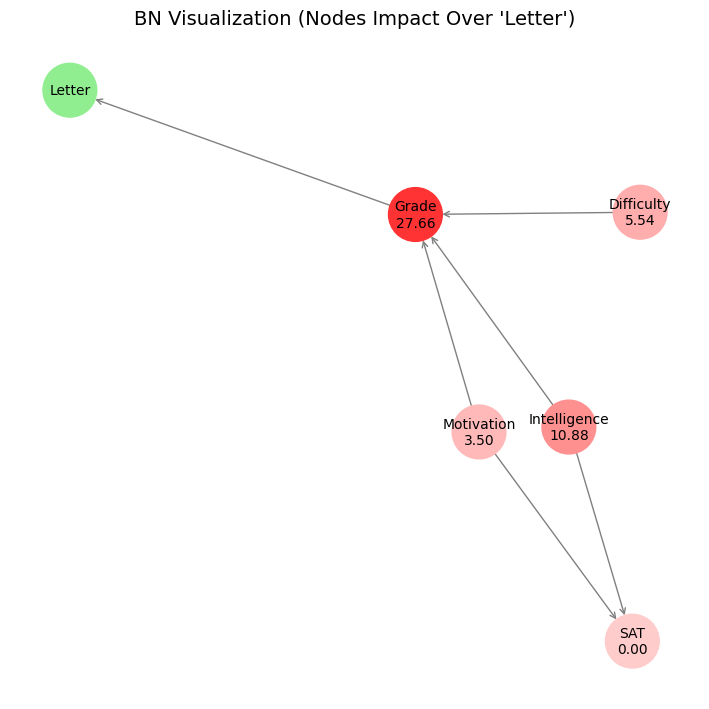

In [42]:
# And also node impacts to Dyspnea using 'do' operation
plot_bn(model, layout=nx.spring_layout, type="impacts", operation='do', target=target)

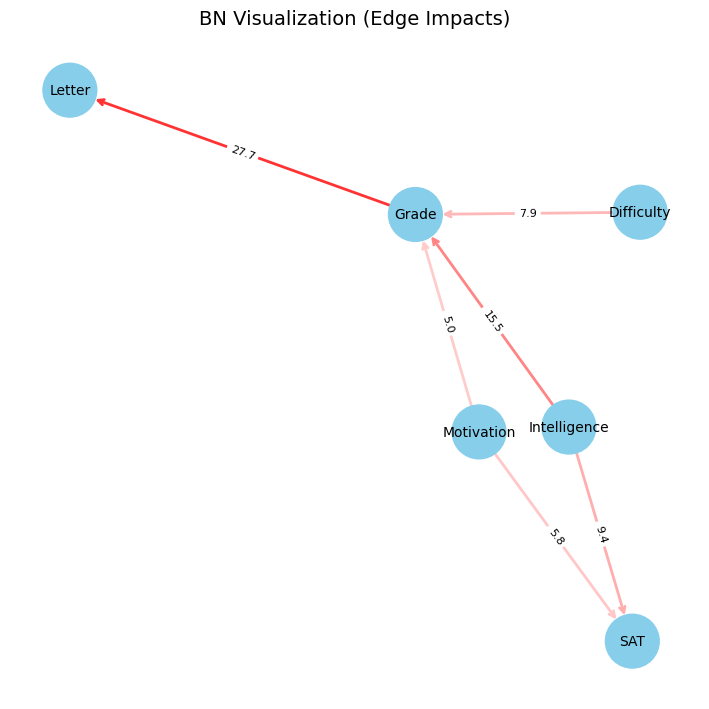

In [44]:
# 4. Edge impacts (must be a fully binary BN)
plot_bn(model, layout=nx.spring_layout, type="edges")

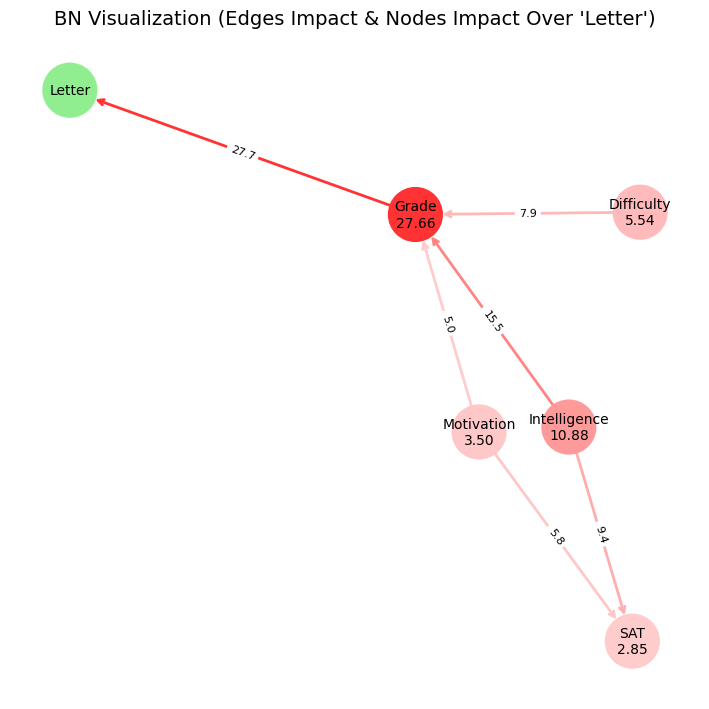

In [46]:
# 5. Node + edge impacts to Dyspnea
plot_bn(model, layout=nx.spring_layout, type="edges_and_impacts", target=target)

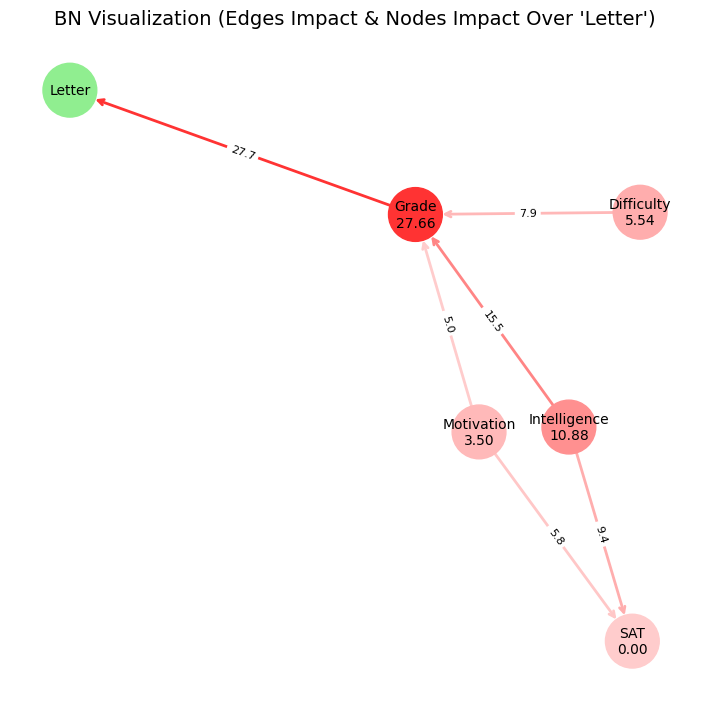

In [50]:
plot_bn(model, layout=nx.spring_layout, operation='do', type="edges_and_impacts", target=target)